In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_30 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-11 10:46:35.551277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=16,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-4)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=300, save_dir=stage1_dir, patience=50,kl_warmup_epochs=240)

[Epoch 50] KL weight: 0.0020, KL: 1.4091
[VAE Pretrain] Epoch 50/300 Avg ELBO: -388.1203 (Recon: -389.5294, KLw: 1.4091)
[Epoch 100] KL weight: 0.0041, KL: 3.0605
[VAE Pretrain] Epoch 100/300 Avg ELBO: -477.2602 (Recon: -480.3207, KLw: 3.0605)
[Epoch 150] KL weight: 0.0062, KL: 4.5858
[VAE Pretrain] Epoch 150/300 Avg ELBO: -492.8156 (Recon: -497.4014, KLw: 4.5858)
[Epoch 200] KL weight: 0.0083, KL: 5.8933
[VAE Pretrain] Epoch 200/300 Avg ELBO: -485.8142 (Recon: -491.7075, KLw: 5.8933)
[Epoch 250] KL weight: 0.0100, KL: 6.4851
[VAE Pretrain] Epoch 250/300 Avg ELBO: -395.9377 (Recon: -402.4228, KLw: 6.4851)
[Epoch 300] KL weight: 0.0100, KL: 7.5192
[VAE Pretrain] Epoch 300/300 Avg ELBO: -528.9195 (Recon: -536.4388, KLw: 7.5192)


In [5]:
stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage1/best_vae.pth'
model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [6]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=90,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0155
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0155
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0154
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0142
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0142
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0142
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0141
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0141
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0142


In [8]:
stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage2/best_som.pth'
model2 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>

In [ ]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 150,kappa= 10, beta= 150, eta= 1,
                                patience = 20)
## modify beta from 1 t0 150, it controls 

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 524096


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep30: Calculating global target P...


[Joint] Ep30 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Ep40: Calculating global target P...


[Joint] Ep40 Global P updated. Shape: torch.Size([524096, 100])


[Joint] Early stopping at epoch 46 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


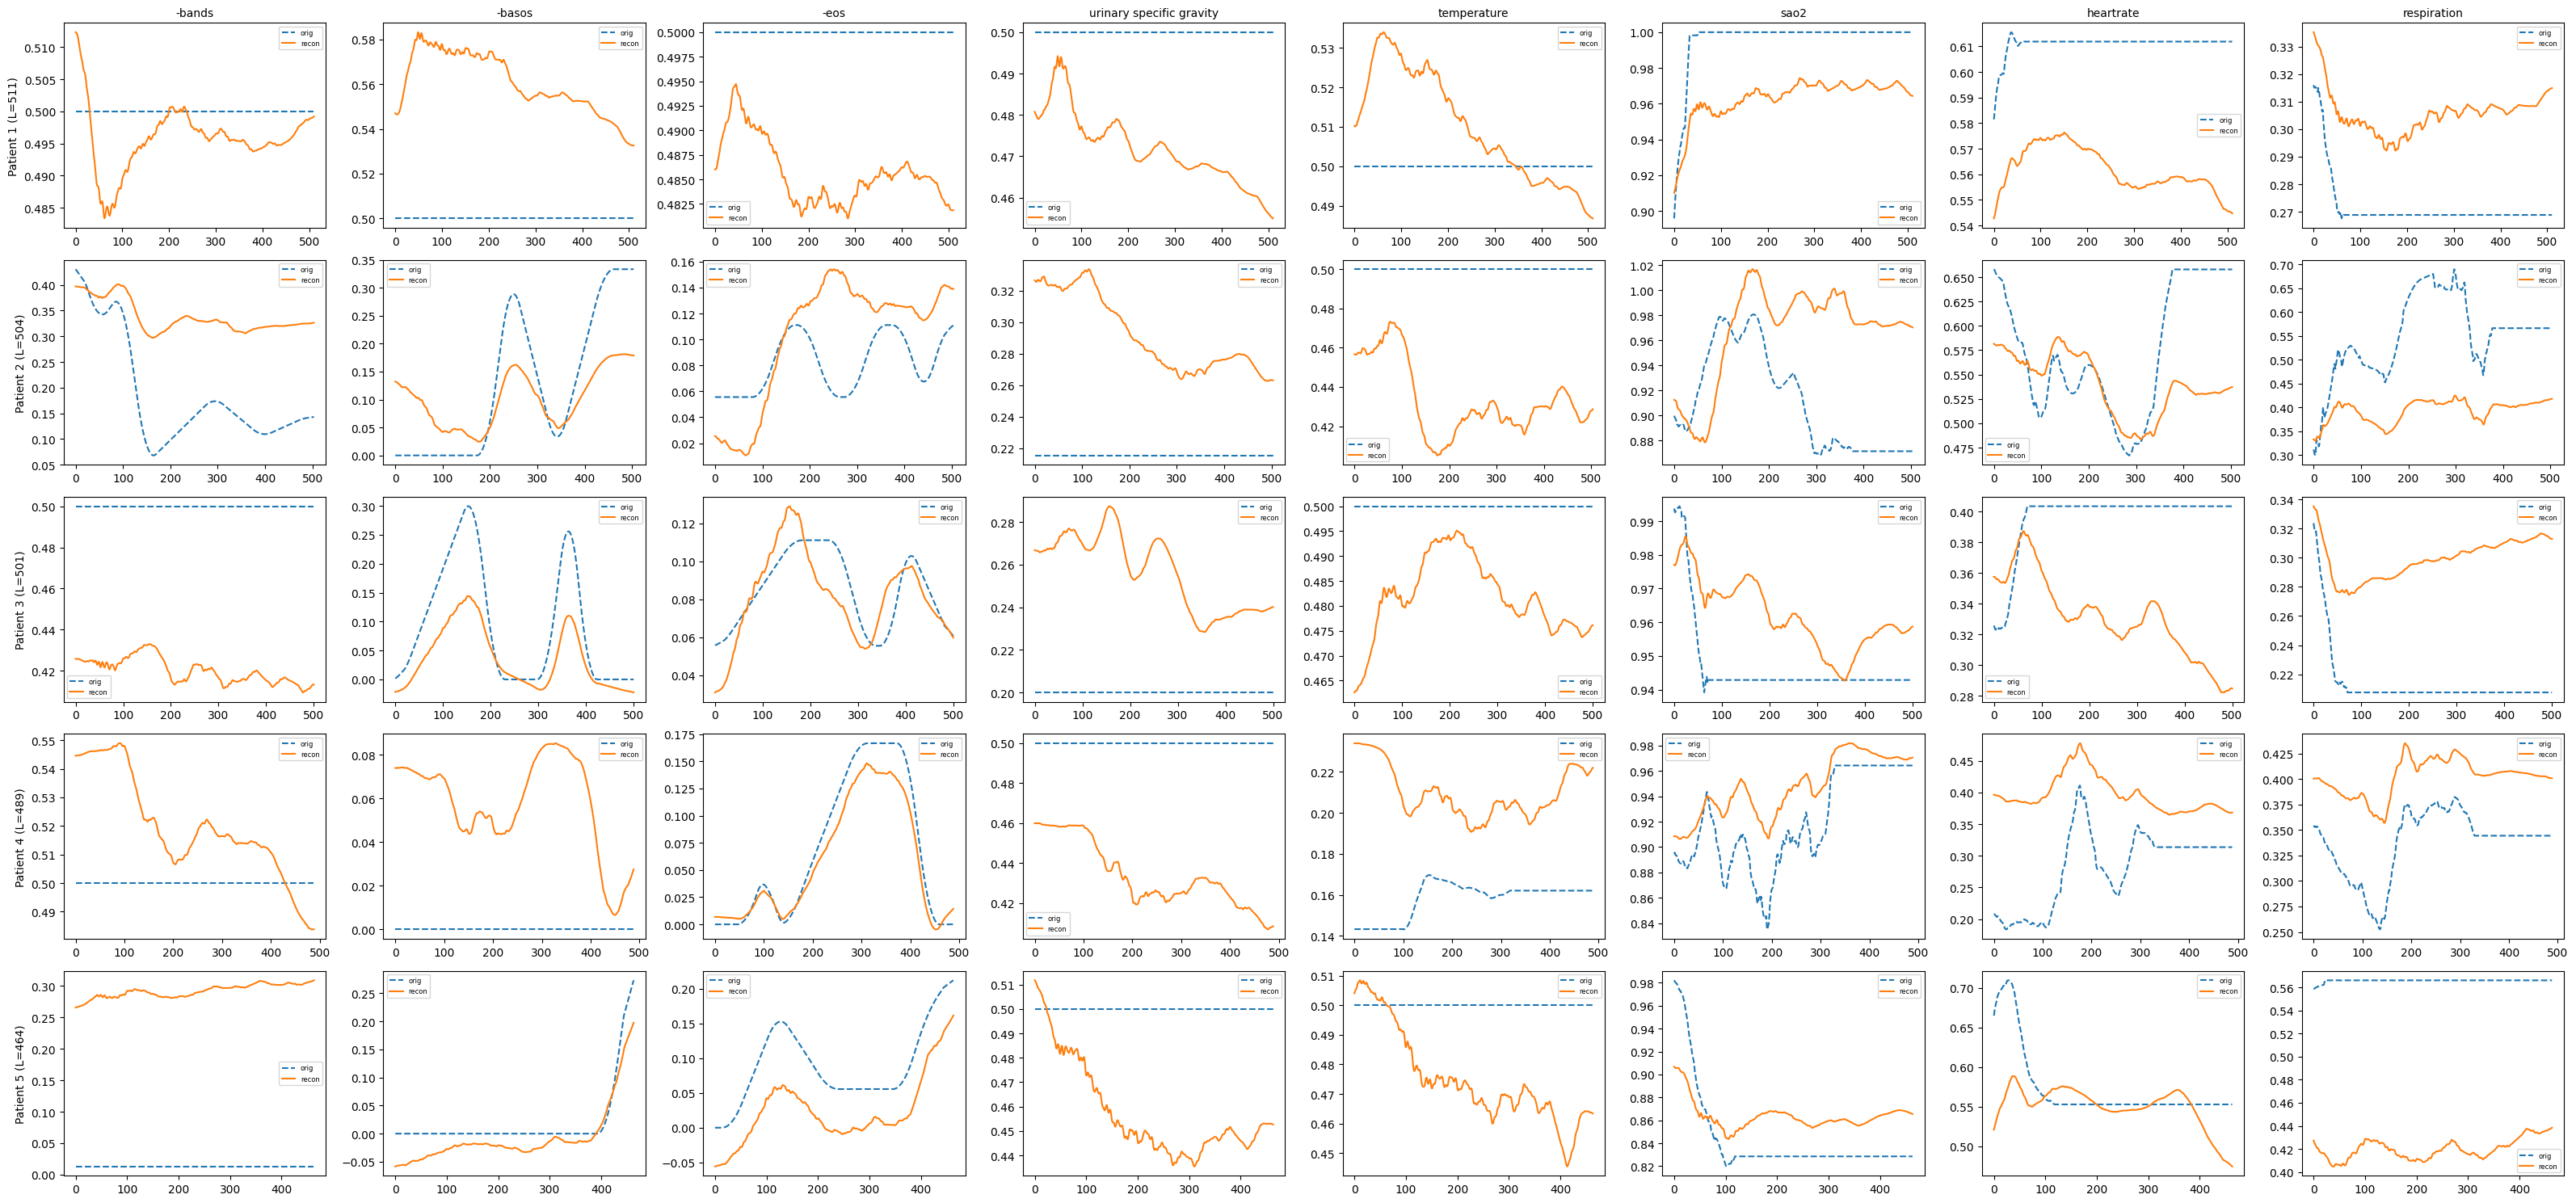

In [10]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 157982 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0075
  Std (overall): 0.4061
  Per-dim mean:
tensor([-0.2188, -0.3033,  0.3305,  0.1562, -0.1228,  0.0395, -0.4484,  0.3331,
         0.0510, -0.1091,  0.4566, -0.3264,  0.2462,  0.1745, -0.1351,  0.0742,
         0.3380, -0.1406,  0.4249,  0.1942,  0.2798,  0.3542, -0.2203,  0.2038,
         0.0752, -0.1883, -0.0189, -0.2942,  0.0849, -0.2407, -0.1624,  0.0132,
        -0.1535, -0.0555,  0.3608, -0.4058, -0.1130, -0.0495,  0.2650,  0.1390,
        -0.1215,  0.1548, -0.2915, -0.0549,  0.0265,  0.3638, -0.0613, -0.1846,
        -0.2457,  0.1767, -0.0623,  0.0953,  0.1426,  0.4809, -0.2569, -0.3748,
        -0.0849, -0.0927, -0.4065,  0.1804,  0.2699,  0.0124, -0.3630,  0.1341,
         0.2084,  0.1433, -0.4623, -0.1005, -0.0853,  0.0928, -0.0048, -0.0199,
         0.3698,  0.0358, -0.3972,  0.1889, -0.0829, -0.2754, -0.3286,  0.2708,
        -0.0590, -0.0910,  0.2518, -0.03

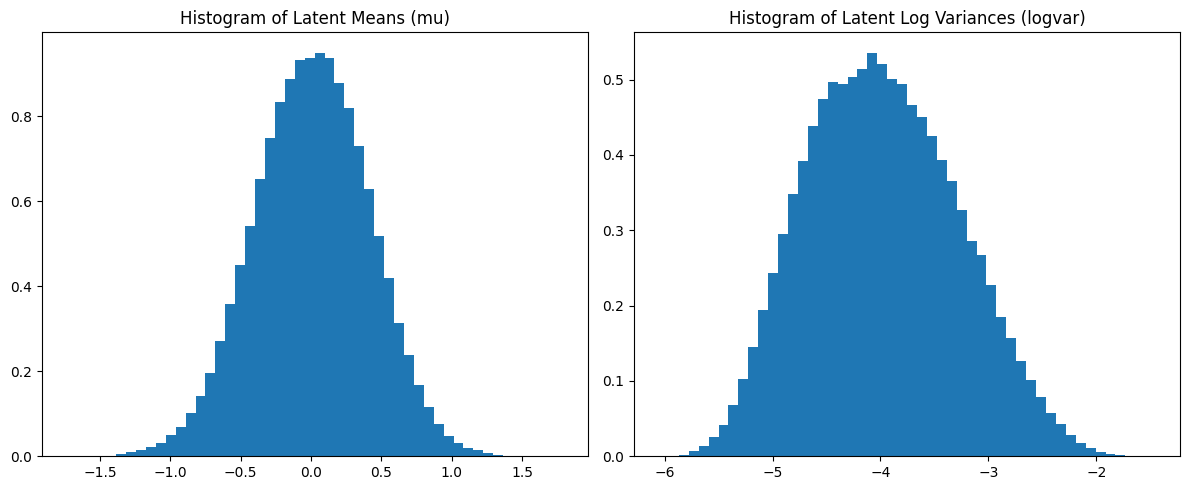

In [11]:
analyze_latent_stats(model3, train_loader, device, num_batches_to_analyze=20)

In [10]:
stage3 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30/stage3/best_joint.pth'
model3 =  TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

model3.load_state_dict(torch.load(stage3, map_location=device,weights_only=True))

<All keys matched successfully>

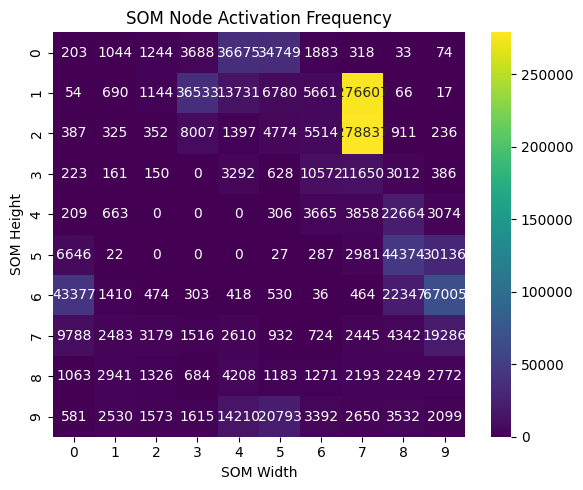

In [12]:
activation_map = compute_som_activation_heatmap(model3, train_loader, device)
plot_som_activation_heatmap(activation_map)

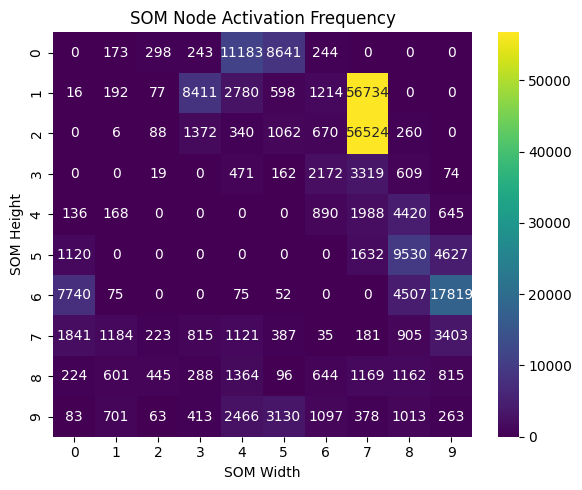

In [13]:
activation_map = compute_som_activation_heatmap(model3,test_loader, device)
plot_som_activation_heatmap(activation_map)

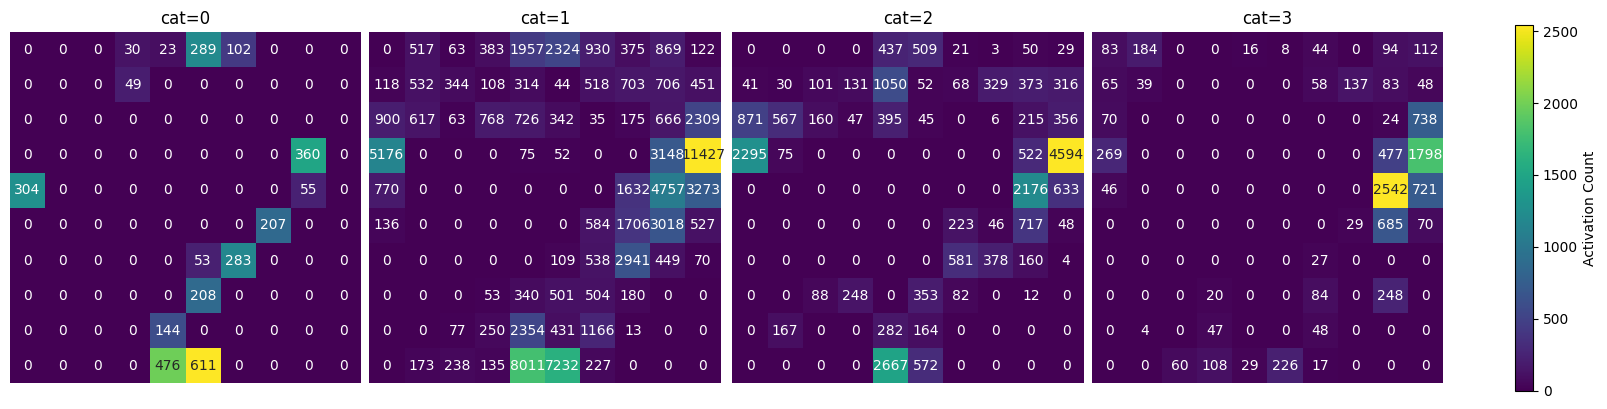

In [14]:

som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model3, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

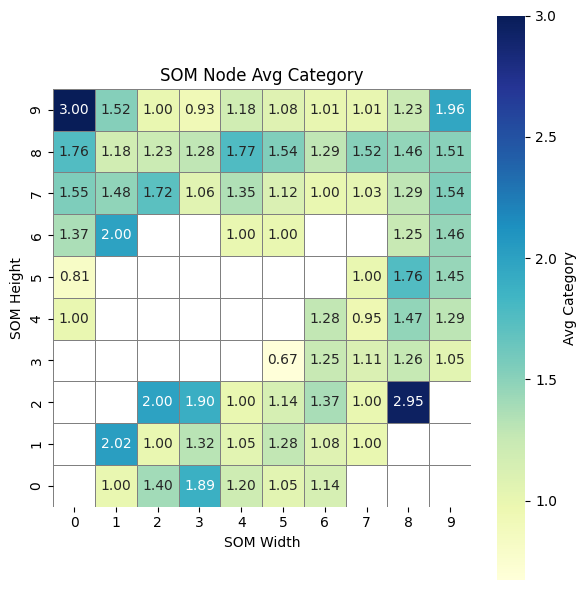

In [15]:

som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model3, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

z_all shape: (118649, 128)
y_all shape: (118649,)


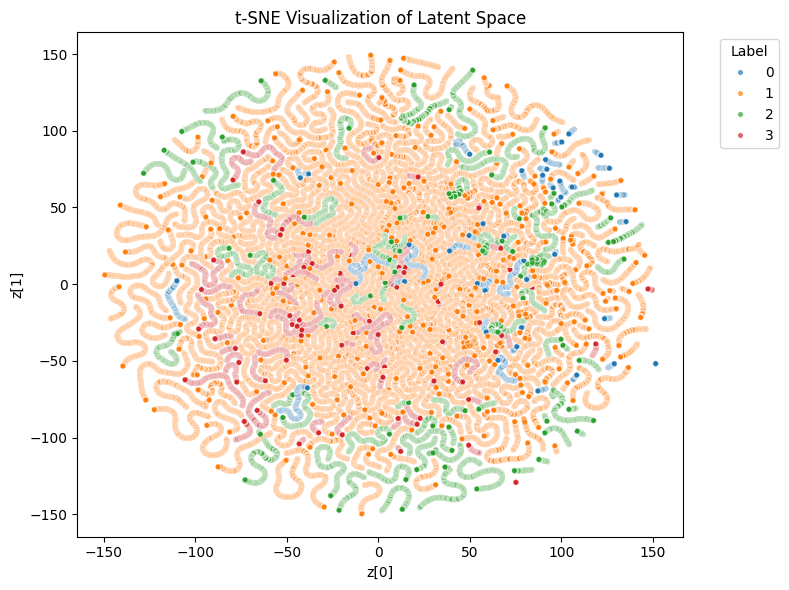

In [16]:
z_all, y_all = collect_latents(model3, data_loader=train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


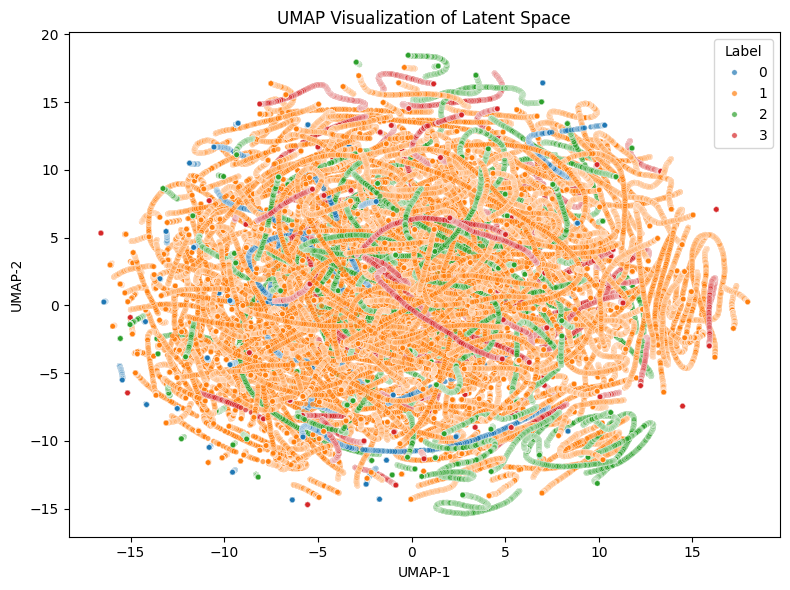

In [17]:
plot_umap(z_all, y_all)